In [3]:
import yfinance as yf
import json
import pandas as pd
import matplotlib.pyplot as plt
import random
from itertools import product

In [4]:
# VPN USA für yfinance

# yfinance testen
isin = "CH0038863350"
ticker = yf.Ticker(isin)
print(ticker.info['longName'])
print(ticker.info['industry'])
print(ticker.info['currency'])
print(ticker.info['previousClose'])

Nestlé S.A.
Packaged Foods
CHF
99.02


In [5]:
test_list = ["CH0012221716", "CH0432492467", "CH0030170408", "CH0010645932", "CH0012214059", "CH0025238863", "CH0025751329", "CH0013841017", "CH0038863350", "CH0012005267",
        "CH0024608827", "CH0210483332", "CH0012032048", "CH0418792922", "CH0012549785", "CH0014852781", "CH0126881561", "CH0008742519", "CH0244767585", "CH0011075394",
        "CH0009002962", "CH0012142631", "CH0319416936", "CH0360674466"]

for item in test_list:
    ticker = yf.Ticker(item)
    print(ticker.info['longName'])

ABB Ltd
Alcon Inc.
Geberit AG
Givaudan SA
Holcim Ltd
Kuehne + Nagel International AG
Logitech International S.A.
Lonza Group AG
Nestlé S.A.
Novartis AG
Partners Group Holding AG
Compagnie Financière Richemont SA
Roche Holding AG
Sika AG
Sonova Holding AG
Swiss Life Holding AG
Swiss Re AG
Swisscom AG
UBS Group AG
Zurich Insurance Group AG
Barry Callebaut AG
Clariant AG
Flughafen Zürich AG
Galenica AG


In [6]:
class Investor:
    # Klassenattribute
    cio_sell_list = ['CH0010645932', 'CH0025238863', 'CH0025751329', 'CH0126881561']
    europe_countries = ['Germany', 'France', 'Netherlands', 'Spain', 'Italy', 'United Kingdom', 'Norway', 'Ireland', 'Europe']
    asia_em_countries = ['Japan', 'Hong Kong', 'China', 'South Korea', 'Taiwan', 'Asia & EM']
    empty_market_allocation = {
        'United States': 0.,
        'Europe': 0.,
        'Switzerland': 0.,
        'Asia & EM': 0.
    }
    empty_sector_allocation = {
        'Financial Services': 0, 
        'Technology': 0., 
        'Industrials': 0., 
        'Energy': 0., 
        'Healthcare': 0., 
        'Consumer Defensive': 0., 
        'Consumer Cyclical': 0., 
        'Basic Materials': 0., 
        'Real Estate': 0., 
        'Communication Services': 0., 
        'Utilities': 0.,
        'Mixed': 0.
    }
    market_colors = {
        'United States': 'green',
        'Europe': 'royalblue',
        'Switzerland': 'red',
        'Asia & EM': 'pink'
    }
    sector_colors = {
        'Financial Services': 'lightblue', 
        'Technology': 'silver', 
        'Industrials': 'steelblue', 
        'Energy': 'orange', 
        'Healthcare': 'lightgreen', 
        'Consumer Defensive': 'tan', 
        'Consumer Cyclical': 'mediumpurple', 
        'Basic Materials': 'saddlebrown', 
        'Real Estate': 'maroon', 
        'Communication Services': 'gold', 
        'Utilities': 'teal',
        'Mixed': 'dimgrey'
    }
    # TO DO: Fetch forex data from API; currently hard-coded (suffices for current requirements)
    forex = {
        'CHF': 1.,
        'EUR': 0.9549,
        'USD': 0.9023,
        'GBP': 1.0953,
        'GBp': 0.010953, # ACHTUNG, GBp (auch manchmal GBX genannt) sind Pence Sterling (1 GBP = 100 GBp = 100 GBx)
        'NOK': 0.0808,
        'JPY': 0.00603,
        'HKD': 0.1153,
        'KRW': 0.00067,
        'TWD': 0.0278
    }

    def __init__(self, id, name, portfolio, investor_type, sector_bias='no_bias', investor_preference='dividends'):
        # Instanzattribute
        self._id = id
        self._name = name
        self._portfolio = portfolio
        self._investor_type = investor_type
        self._sector_bias = sector_bias
        self._investor_preference =  investor_preference
        self._portfolio_curreny = 'CHF'     # Momentan fix CHF
        self._portfolio_value = 0
        self._bulk_risks = []
        self._sell_stocks = []
        self._market_allocation = {}
        self._sector_allocation = {}
        self._market_allocation_difference = {}
        self._sector_allocation_difference = {}
        self._portfolio_beta = 0
        self._high_beta_stocks = []
        self._something_essential = []
        self._something_similar_alpha = []
        self._something_similar_beta = []

    # Methoden
    def get_name(self):
        return f"Investor's name is {self._name}."

    def find_sell_stocks(self):
        # Portfolio durchsuchen nach Aktien, die auf der Sell-Liste sind
        for i in range(len(self._portfolio)):
            if self._portfolio[i]['isin'] in Investor.cio_sell_list and self._portfolio[i]['isin'] not in self._sell_stocks:
                self._sell_stocks.append(self._portfolio[i]['isin'])
                print(f"Attention! ISIN {self._portfolio[i]['isin']} is on the CIO 'Least Preferred' list.")
        if self._sell_stocks == []:
            print(f"No current positions in the portfolio are on the CIO 'Least Preferred' list.")

    def buy(self, isin, quantity):
        # Aktie kaufen

        # Überprüfen, ob ISIN existiert
        stock_info = pd.read_csv('..\data\stock_info.tsv', sep='\t') # TSV als Pandas-df
        existing_isin = isin in stock_info['isin'].values
        if not existing_isin:
            return print(f'ISIN could not be found. Please check your input.')
        
        else:
            # print(f"Buying {quantity} units of ISIN {isin}...")

            # Checken, ob bereits im Portfolio
            already_bought = False
            for i in range(len(self._portfolio)): # Mehrfache Einträge der selben Aktie vermeiden; Position erhöhen
                if self._portfolio[i]['isin'] == isin: # Falls Position im Portfolio, vorhandene Position erhöhen
                    already_bought = True
                    print(f'Position already in portfolio, increasing quantity by {quantity}.')
                    self._portfolio[i]['quantity'] += quantity
                    print(f'Updated position: {self._portfolio[i]["quantity"]} units of ISIN {self._portfolio[i]["isin"]}')
                    break
            if already_bought == False: # Falls noch nicht im Portfolio, neue Position
                self._portfolio.append({'isin':isin, 'quantity':quantity})
                print(f'New position. Successfully bought {quantity} units of ISIN {isin}.')

            # print(f'Purchase successfully completed!')

    def sell(self, isin, quantity):
        # Aktie verkaufen
        for position in self._portfolio:
            if position['isin'] == isin and position['quantity'] >= quantity: # nur verkaufen wenn ISIN im Portfolio und genügend Einheiten
                position['quantity'] -= quantity
                print(f"Sold {quantity} units of ISIN {isin}.")
                if position['quantity'] == 0:
                    self._portfolio.remove(position)
                    print(f"Portfolio now holds 0 units of ISIN {isin}. Position removed.")
                self.fetch_portfolio_infos()
                return
        print(f"ISIN {isin} is not in the portfolio or there are fewer than {quantity} units in the portfolio.")


    def fetch_portfolio_infos(self):
        # aus stock_info Daten zu den Positionen fetchen & zuweisen
        print('Fetching data for each portfolio position.')
        stock_info = pd.read_csv('..\data\stock_info.tsv', sep='\t') # TSV als Pandas-df
        # stock_info = stock_info.fillna(0)

        self._portfolio_value = 0

        for position in self._portfolio:
            # Infos zum relevanten Stock extrahieren
            info = stock_info.loc[stock_info['isin'] == position['isin'], ['isin', 'longName', 'previousClose', 'currency', 'country' , 'sector', 'industry', 'dividendYield', 'beta', 'trailingPE', '52WeekChange']] # zeile aus stock-info von dieser Aktie
            
            # Infos zuweisen
            position['name'] = info['longName'].values[0]       # Name
            position['currency'] = info['currency'].values[0]   # Währung
            if 'buy_price' not in position: # Kaufpreis, wird nur geschrieben, wenn davor keiner vorhanden war. Damit nicht bei späteren Updates überschrieben wird
                position['buy_price'] = round(info['previousClose'].values[0], 2) # Kaufpreis
            position['price'] = round(info['previousClose'].values[0], 2) # Preis
            position['value'] = round(position['quantity']*position['price']*Investor.forex[position['currency']], 2) # Wert = Anzahl*Preis*Wechselkurs
            self._portfolio_value += position['value']          # Gesamt-Portfoliowert aktualisieren
            position['sector'] = info['sector'].values[0]       # Sektor
            position['industry'] = info['industry'].values[0]   # Subsektor
            position['country'] = info['country'].values[0]     # Land
            position['dividend'] = info['dividendYield'].values[0]  # Dividende
            position['beta'] = info['beta'].values[0]               # Beta
            position['trailingPE'] = info['trailingPE'].values[0]   # PE
            position['52WeekChange'] = info['52WeekChange'].values[0] # Prozentuale Veränderung letzte 52 Wochen

            # Region für Allokation
            if position['country'] in Investor.europe_countries:
                position['region'] = 'Europe'
            elif position['country'] in Investor.asia_em_countries:
                position['region'] = 'Asia & EM'
            else:
                position['region'] = position['country'] # Switzerland & United States

        # Anteil am Portfoliowert für jede Position
        print('Updating portfolio percentage.')
        self._bulk_risks = []
        for position in self._portfolio:
            position['portfolio_percent'] = round(position['value']/self._portfolio_value, 4)
            if  position['portfolio_percent'] >= 0.1:
                self._bulk_risks.append(position['isin'])
                print(f"Bulk risk detected for ISIN {position['isin']}.")
        print('All infos fetched and positions updated.')
        print(f"Updated portfolio value: {self._portfolio_value}")

        # Bugfix: GBp auf GBP ändern
        for position in self._portfolio:
            if position['currency'] == 'GBp':
                position['currency'] = 'GBP'
                position['price'] = position['price']/100
                position['buy_price'] = position['buy_price']/100
        print('Fixed GBp')

    def calculate_allocation(self):
        # Berechnung der Markt- und Sektorallokation des Portfolios
        print('Calculating Market and Sector Allocation.')

        # Zuerst: Leere Allokation
        self._market_allocation = dict(Investor.empty_market_allocation)
        self._sector_allocation = dict(Investor.empty_sector_allocation)
        
        # Aggregation
        for position in self._portfolio:
            region = position['region']
            self._market_allocation[region] += position['portfolio_percent']
            sector = position['sector']
            self._sector_allocation[sector] += position['portfolio_percent']
        if self._sector_allocation['Mixed'] == 0:
            del self._sector_allocation['Mixed']
        print('Allocation successfully calculated.')

    def visualize_allocations(self, market=True, sector=True):
        # Allokation Visualisieren
        if market: # Markt Allokation
            market_label_list = []
            market_size_list = []
            market_color_list = []
            for market in self._market_allocation:
                if self._market_allocation[market] != 0: # Leere Werte rausnehmen für klarere Visualisierung
                    market_label_list.append(market)
                    market_size_list.append(self._market_allocation[market])
                    market_color_list.append(Investor.market_colors[market])

            plt.pie(x=market_size_list, labels=market_label_list, autopct='%1.1f%%', colors=market_color_list, wedgeprops=dict(edgecolor='black'))
            plt.title('Market Allocation')
            plt.show()

        if sector: # Sektor Allokation
            sector_label_list = []
            sector_size_list = []
            sector_color_list = []
            for sector in self._sector_allocation:
                if self._sector_allocation[sector] != 0:
                    sector_label_list.append(sector)
                    sector_size_list.append(self._sector_allocation[sector])
                    sector_color_list.append(Investor.sector_colors[sector])

            plt.pie(x=sector_size_list, labels=sector_label_list, autopct='%1.1f%%', colors=sector_color_list, wedgeprops=dict(edgecolor='black'))
            plt.title('Sector Allocation')
            plt.show()
    
    def calculate_allocation_difference(self):
        # Unterschied zwischen Kunden-Allokation und Benchmark-Allokation
        print(f'Comparing portfolio to benchmark allocation.')
        self._market_allocation_difference = dict(Investor.empty_market_allocation)
        self._sector_allocation_difference = dict(Investor.empty_sector_allocation)

        # print(f'Investor profile: {self._investor_type}')

        with open(f'..\data\profile_{self._investor_type}.json') as json_file:
            reference_allocation = json.load(json_file)

        for market in self._market_allocation:
            self._market_allocation_difference[market] = self._market_allocation[market] - reference_allocation['markets'][market]
        
        for sector in self._sector_allocation:
            self._sector_allocation_difference[sector] = self._sector_allocation[sector] - reference_allocation['sectors'][sector]
        print('Allocation differences were calculated successfully.')

    def visualize_allocation_differences(self, market=True, sector=True):
        # Allokations-Verletzungen visualisieren
        if market:
            market_diff_labels = []
            market_diff_sizes = []
            market_diff_colors = []
            for market in self._market_allocation_difference:
                market_diff_labels.append(market)
                market_diff_sizes.append(round(self._market_allocation_difference[market]*100, 2))
                market_diff_colors.append(Investor.market_colors[market])
            plt.figure(figsize=(6,6))
            plt.bar(x=market_diff_labels, height=market_diff_sizes, color=market_diff_colors)
            for i in range(len(market_diff_sizes)):
                plt.text(i, market_diff_sizes[i]//2, str(market_diff_sizes[i])+'%', ha = 'center')
            plt.xlabel('Market')
            plt.ylabel('Difference to Benchmark in %')
            plt.show

        if sector:
            sector_diff_labels = []
            sector_diff_sizes = []
            sector_diff_colors = []
            for sector in self._sector_allocation_difference:
                sector_diff_labels.append(sector)
                sector_diff_sizes.append(round(self._sector_allocation_difference[sector]*100, 2))
                sector_diff_colors.append(Investor.sector_colors[sector])
            plt.figure(figsize=(12,6))
            plt.bar(x=sector_diff_labels, height=sector_diff_sizes, color=sector_diff_colors)
            for i in range(len(sector_diff_sizes)):
                plt.text(i, sector_diff_sizes[i]//2, str(sector_diff_sizes[i])+'%', ha = 'center')
            plt.xlabel('Sector')
            plt.xticks(rotation=90)
            plt.ylabel('Difference to Benchmark in %')
            plt.show

    def print_portfolio(self):
        # Portfolio anzeigen
        if len(self._portfolio) == 0: # leeres Portfolio, abbrechen mit Nachricht
            return print('There are currently no positions in the portfolio.')
        if 'currency' not in self._portfolio[-1]: # Infos noch nicht gefetcht, abbrechen mit Nachricht
            return print('Please fetch stock info first.')
        
        print(f'Currency\tQuantity\tName\t\t\t\tISIN\t\tBuy Price\tMarket Price\tMarket Value')
        print(f'----------------------------------------------------------------------------------------------------------------------------')
        for position in self._portfolio:
            spaces = 30 - len(position['name'][:30])
            print(f"{position['currency']}\t\t{position['quantity']}\t\t{position['name'][:30]}{spaces*' '}\t{position['isin']}\t{position['buy_price']}\t\t{position['price']}\t\t{position['value']}")
            print(f'----------------------------------------------------------------------------------------------------------------------------')

    def calculate_portfolio_beta(self):
        """
        Grobe Risikoabschätzung, in Zukunft ersetzen mit Varianzberechnung
        """
        self._portfolio_beta = 0 # reset portfolio beta
        self._high_beta_stocks = []
        for position in self._portfolio:
            self._portfolio_beta += (position['beta']*position['portfolio_percent'])
            if position['beta'] >= 1.5:
                self._high_beta_stocks.append(position['isin'])
        self._portfolio_beta = round(self._portfolio_beta, 2)
        print(f"Updated Portfolio-Beta. It's currently at {self._portfolio_beta}")

    def write_json(self):
        json_object = json.dumps(self.__dict__, indent=4, ensure_ascii=False)
        id = self._id
        with open(f'{id}.json', 'w', encoding='utf-8') as outfile:
            json_object = json_object.replace("NaN", '"NaN"')
            outfile.write(json_object)
        print(f"Successfully created JSON file named {id}.json")
    
    def generate_json(self):
        json_object = json.dumps(self.__dict__, indent=4, ensure_ascii=False)
        json_object = json_object.replace("NaN", '"NaN"') # NaN Werte die beim Scraping verloren gehen ersetzen
        return json_object

    def __str__(self) -> str:
        return f"Investor's name is {self._name}."
    
    def __repr__(self):
        return f"{self._name}"

__________________
## Personas & Bias - Bulding Dummy Portfolios
__________________

In [7]:
def build_dummy_investor(dummy_id:str, dummy_name:str, dummy_investor_type:str, dummy_sector_bias:str, dummy_investor_preference:str):
    investor = Investor(id=dummy_id, name=dummy_name, portfolio=[], investor_type=dummy_investor_type, sector_bias=dummy_sector_bias, investor_preference=dummy_investor_preference)
    basic_portfolio = {
        'CH0038863350': 690, # Nestle
        'CH0012005267': 810, # Novartis
        'CH0012032048': 275, # Roche
        'CH0012221716':1500, # ABB
        'CH0011075394': 170, # Zurich Insurance
        'CH0030170408': 100, # Geberit
        'CH0008742519':  80, # Swisscom
        'CH0012214059': 800, # Holcim
        'FR0000121014':  60, # LVMH
        'FR0000120321': 110, # L'Oreal
        'FR0000120271': 600, # TotalEnergies
        'US0378331005': 210, # Apple
        'US5949181045': 105, # Microsoft
        'US92826C8394': 150  # Visa
    }

    bias_dict = {}

    it_bias = {
        'US67066G1040': 170, # Nvidia
        'CH0025751329':1250, # Logitech
        'DE0007164600': 700, # SAP
        'KYG875721634':2400, # Tencent
        'US0378331005': 300, # Apple Basis aufstocken
        'US5949181045': 170, # Microsoft Basis aufstocken
    }

    finance_bias = {
        'CH0102484968': 1400, # Julius Baer
        'DE0008404005':  380, # Allianz
        'GB0031348658':48000, # Barclays
        'FR0000131104': 1500, # BNP Paribas
        'US92826C8394':  220, # Visa Basis aufstocken
    }

    fashion_bias = {
        'ES0148396007':2400, # Inditex
        'US6541061031': 900, # Nike
        'US7512121010': 800, # Ralph Lauren
        'FR0000121014':  70, # LVMH Basis aufstocken
    }

    industrial_bias = {
        'CH0030170408':  80, # Geberit Basis aufstocken
        'FR0000125486': 820, # Vinci
        'US2910111044': 950, # Emmerson Electric
        'CH0012221716': 950, # ABB Basis aufstocken
    }

    car_bias = {
        'JP3633400001':5000, # Toyota
        'NL00150001Q9':4600, # Stellantis
        'NL0011585146': 290, # Ferrari
    }

    risk_bias = {
        'GB00B7KR2P84':20000, # easyJet
        'NL0011821202': 3400, # ING
        'US67066G1040':  100, # NVIDIA
        'DE0006231004': 1300, # Infineon
        'FR0000131104':  800, # BNP Paribas
        'US0079031078':  420, # AMD
    }

    no_bias = {}

    bias_dict['it_bias'] = it_bias
    bias_dict['finance_bias'] = finance_bias
    bias_dict['fashion_bias'] = fashion_bias
    bias_dict['industrial_bias'] = industrial_bias
    bias_dict['car_bias'] = car_bias
    bias_dict['risk_bias'] = risk_bias
    bias_dict['no_bias'] = no_bias

    # Basic Portfolio
    for key, value in basic_portfolio.items():
        investor.buy(isin=key, quantity=value)

    # Bias
    for key, value in bias_dict[dummy_sector_bias].items():
        investor.buy(isin=key, quantity=value)

    investor.find_sell_stocks()
    investor.fetch_portfolio_infos()
    investor.calculate_allocation()
    investor.calculate_allocation_difference()
    investor.calculate_portfolio_beta()
    investor.write_json()

    return investor

In [8]:
# Creating Dummy Investors according to Personas
dummy_info = {'000001':['Lenny Linux', 'swiss-bias', 'it_bias', 'performance'], 
              '000002':['Benny Banker', 'swiss-global', 'finance_bias', 'dividends'], 
              '000003':['Louise Vuitton', 'global', 'fashion_bias', 'low_volatility'], 
              '000004':['Robby Robotic', 'swiss-bias', 'industrial_bias', 'low_pe'], 
              '000005':['Freddy Ferrari', 'swiss-global', 'car_bias', 'performance'], 
              '000006':['Ricky Risk', 'global', 'risk_bias', 'performance']
              }

dummy_investors = []

for id in dummy_info:
    name = dummy_info[id][0]
    investor_type = dummy_info[id][1]
    sector_bias = dummy_info[id][2]
    investor_preference = dummy_info[id][3]
    investor = build_dummy_investor(dummy_id=id, dummy_name=name, dummy_investor_type=investor_type, 
                         dummy_sector_bias=sector_bias, dummy_investor_preference=investor_preference)
    dummy_investors.append(investor)
dummy_investors

New position. Successfully bought 690 units of ISIN CH0038863350.
New position. Successfully bought 810 units of ISIN CH0012005267.
New position. Successfully bought 275 units of ISIN CH0012032048.
New position. Successfully bought 1500 units of ISIN CH0012221716.
New position. Successfully bought 170 units of ISIN CH0011075394.
New position. Successfully bought 100 units of ISIN CH0030170408.
New position. Successfully bought 80 units of ISIN CH0008742519.
New position. Successfully bought 800 units of ISIN CH0012214059.
New position. Successfully bought 60 units of ISIN FR0000121014.
New position. Successfully bought 110 units of ISIN FR0000120321.
New position. Successfully bought 600 units of ISIN FR0000120271.
New position. Successfully bought 210 units of ISIN US0378331005.
New position. Successfully bought 105 units of ISIN US5949181045.
New position. Successfully bought 150 units of ISIN US92826C8394.
New position. Successfully bought 170 units of ISIN US67066G1040.
New positio

[Lenny Linux,
 Benny Banker,
 Louise Vuitton,
 Robby Robotic,
 Freddy Ferrari,
 Ricky Risk]

________
## Something Essential
________

In [9]:
# Relevante Daten vorbereiten
def prepare_reduced_stock_info():
    stock_info = pd.read_csv('..\data\stock_info.tsv', sep='\t') # TSV als Pandas-df
    selected_columns = ['isin', 'longName', 'country', 'sector', 'industry', 'beta', 'dividendYield', 'trailingPE', '52WeekChange', 'currency']
    reduced_stock_info = stock_info[selected_columns]

    europe_countries = ['Germany', 'France', 'Netherlands', 'Spain', 'Italy', 'United Kingdom', 'Norway', 'Ireland', 'Europe']
    asia_em_countries = ['Japan', 'Hong Kong', 'China', 'South Korea', 'Taiwan', 'Asia & EM']
    reduced_stock_info.loc[reduced_stock_info['country'].isin(europe_countries), 'country'] = 'Europe'
    reduced_stock_info.loc[reduced_stock_info['country'].isin(asia_em_countries), 'country'] = 'Asia & EM'
    return reduced_stock_info

def something_essential(investor):
    print(f'Preparing recommendation for "Something Essential"\n------------------------------------')
    print(f'Investor Preference: {investor._investor_preference}; choosing accordingly\n------------------------------------')

    # Kombinationen von Märkten und Sektoren mit grösstem Handlungsbedarf finden
    market_diff = investor._market_allocation_difference
    sector_diff = investor._sector_allocation_difference
    market_diff = {key: value for key, value in market_diff.items() if value < 0} # nur Untergewichtungen miteinbeziehen
    sector_diff = {key: value for key, value in sector_diff.items() if value < 0}
    key_pairs = list(product(market_diff.keys(), sector_diff.keys())) # Paare bilden aus Märkten und Sektoren
    sum_values = {pair: market_diff[pair[0]] + sector_diff[pair[1]] for pair in key_pairs}
    top_pairs = sorted(sum_values.items(), key=lambda x: x[1], reverse=False) # nach Handlungsbedarf filtern
    print(top_pairs)

    recommendations = []
    counter = 5 # maximale Anzahl Vorschläge

    for i in range(len(top_pairs)): # so viele Markt-Sektor-Paare sollen maximal betrachtet werden
        reduced_stock_info = prepare_reduced_stock_info() # Relevante Daten vorbereiten
        if counter > 0: # nur empfehlen solange maximale Anzahl Vorschläge noch nicht erreicht
            if counter == 5:    # Vorschlags-Diversität: nicht alle Vorschläge zum selben Problem vorschlagen
                budget = 3      # bis zu 3 Aktien zum grössten Handlungsbedarf
            elif counter == 4:
                budget = 2      # bis zu 2 Aktien wenn noch 4 Vorschläge verbleiben
            else:
                budget = 1      # anschliessend jeweils 1 Aktie vorschlagen

            recommendation_text = []

            country = top_pairs[i][0][0]
            sector = top_pairs[i][0][1]

            # Nach Land und Sektor filtern
            reduced_stock_info = reduced_stock_info.loc[(reduced_stock_info['country'] == country) & (reduced_stock_info['sector'] == sector)]
            recommendation_text.append(f'Untergewicht {country}')
            recommendation_text.append(f'Untergewicht {sector}')

            print(f'Preparing recommendation for {country} + {sector}.')

            # Wenn Portfolio-Beta zu hoch, nur noch Aktien mit tiefem Beta empfehlen oder wenn Präferenz
            if investor._portfolio_beta > 0.95 or investor._investor_preference == 'low_volatility':
                reduced_stock_info = reduced_stock_info.loc[reduced_stock_info['beta'] <= 0.8]
                reduced_stock_info = reduced_stock_info.sort_values(by='beta', ascending=True)
                if investor._investor_preference == 'low_volatility':
                    recommendation_text.append('Deine Präferenz: Tiefe Volatilität')
                elif investor._portfolio_beta > 0.95:
                    recommendation_text.append('Reduktion Potfoliorisiko')

            # Präferenz Dividenden
            elif investor._investor_preference == 'dividends':
                reduced_stock_info = reduced_stock_info.sort_values(by='dividendYield', ascending=False)
                recommendation_text.append('Deine Präferenz: Hohe Dividende')

            # Präferenz tiefe P/E, günstige Aktien
            elif investor._investor_preference == 'low_pe':
                reduced_stock_info = reduced_stock_info.sort_values(by='trailingPE', ascending=True)
                recommendation_text.append('Deine Präferenz: Tiefe P/E Ratio')

            # Präferenz Performance (Jährlich)
            elif investor._investor_preference == 'performance':
                reduced_stock_info = reduced_stock_info.loc[reduced_stock_info['52WeekChange'] >= -0.1]
                reduced_stock_info = reduced_stock_info.sort_values(by='52WeekChange', ascending=False)
                recommendation_text.append('Deine Präferenz: Performance (jährlich)')

            reduced_stock_info.reset_index(drop=True, inplace=True)

            possible_reccomendations = len(reduced_stock_info)

            for j in range(min(budget, possible_reccomendations)):
                recommendations.append({
                    'isin': reduced_stock_info['isin'][j],
                    'name': reduced_stock_info['longName'][j],
                    'currency': reduced_stock_info['currency'][j],
                    'sector':  reduced_stock_info['sector'][j],
                    'industry':  reduced_stock_info['industry'][j],
                    'region':  reduced_stock_info['country'][j],
                    'dividend': reduced_stock_info['dividendYield'][j],
                    'beta': reduced_stock_info['beta'][j],
                    'trailingPE': reduced_stock_info['trailingPE'][j],
                    '52WeekChange': reduced_stock_info['52WeekChange'][j],
                    'text': recommendation_text
                    })
                counter -= 1
                
                print(f'{len(recommendations)}. Vorschlag: {reduced_stock_info["longName"][j]}')

    print(f'------------------------------------\nRecommendation successfully prepared\n------------------------------------')
    return recommendations


Ricky Risk
Preparing recommendation for "Something Essential"
------------------------------------
Investor Preference: performance; choosing accordingly
------------------------------------
[(('United States', 'Consumer Cyclical'), -0.3057), (('United States', 'Consumer Defensive'), -0.2999), (('United States', 'Real Estate'), -0.2851), (('United States', 'Utilities'), -0.2851), (('United States', 'Energy'), -0.27790000000000004), (('United States', 'Basic Materials'), -0.27749999999999997), (('United States', 'Technology'), -0.2732), (('United States', 'Communication Services'), -0.27040000000000003), (('Asia & EM', 'Consumer Cyclical'), -0.1406), (('Asia & EM', 'Consumer Defensive'), -0.1348), (('Asia & EM', 'Real Estate'), -0.12000000000000001), (('Asia & EM', 'Utilities'), -0.12000000000000001), (('Asia & EM', 'Energy'), -0.11280000000000001), (('Asia & EM', 'Basic Materials'), -0.1124), (('Asia & EM', 'Technology'), -0.10810000000000003), (('Asia & EM', 'Communication Services'),

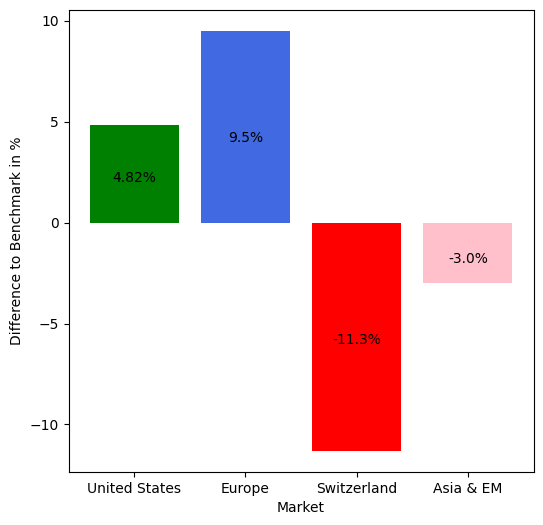

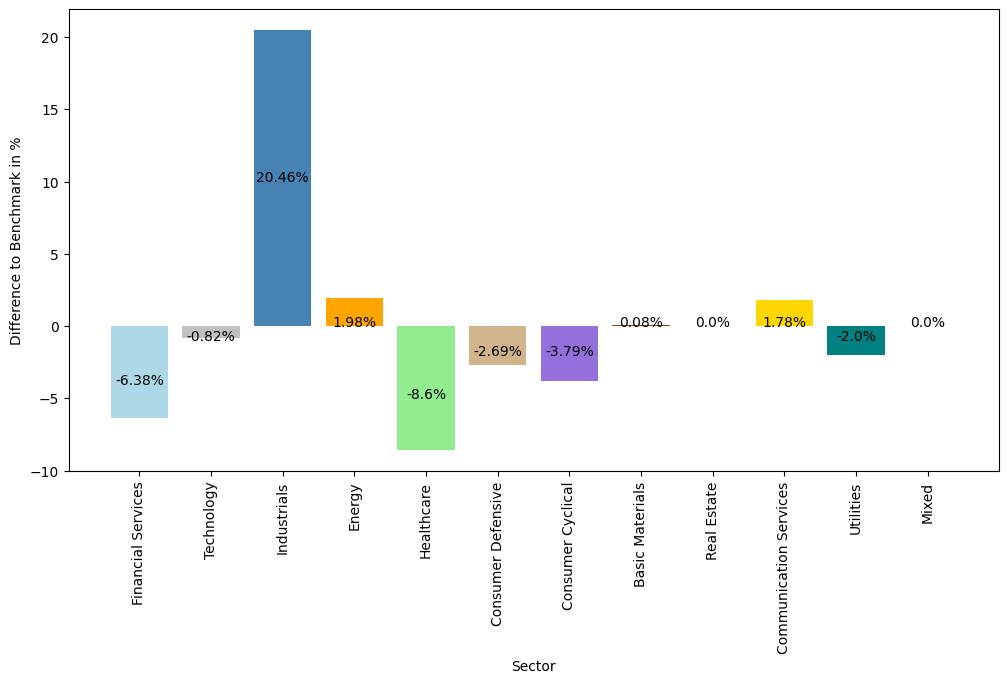

In [10]:
print(dummy_investors[5]._name)
something_essential(dummy_investors[5])
dummy_investors[3].visualize_allocation_differences()

In [11]:
# Recommendation Something Essential für jeden Dummy Persona Investor
for dummy_investor in dummy_investors:
    print(dummy_investor._name)
    dummy_investor._something_essential = something_essential(dummy_investor)
    dummy_investor.write_json()

Lenny Linux
Preparing recommendation for "Something Essential"
------------------------------------
Investor Preference: performance; choosing accordingly
------------------------------------
[(('Switzerland', 'Healthcare'), -0.31259999999999993), (('Switzerland', 'Financial Services'), -0.28389999999999993), (('Switzerland', 'Industrials'), -0.26519999999999994), (('Switzerland', 'Consumer Defensive'), -0.24809999999999993), (('Switzerland', 'Consumer Cyclical'), -0.24529999999999993), (('Switzerland', 'Utilities'), -0.22019999999999992), (('Switzerland', 'Basic Materials'), -0.20799999999999993)]
Preparing recommendation for Switzerland + Healthcare.
1. Vorschlag: Alcon Inc.
2. Vorschlag: Novartis AG
3. Vorschlag: Galenica AG
Preparing recommendation for Switzerland + Financial Services.
4. Vorschlag: UBS Group AG
Preparing recommendation for Switzerland + Industrials.
5. Vorschlag: VAT Group AG
------------------------------------
Recommendation successfully prepared
---------------

_______
## Some Testing and Data Understanding
_______

In [12]:
# high beta stocks
stock_info = pd.read_csv('..\data\stock_info.tsv', sep='\t') # TSV als Pandas-df
selected_columns = ['longName', 'beta']
sorted_stock_info = stock_info[selected_columns].sort_values(by='beta', ascending=False)
print(sorted_stock_info.head(20))

                         longName      beta
70                    easyJet plc  2.506493
49                 ING Groep N.V.  1.694000
108            NVIDIA Corporation  1.684000
48       Infineon Technologies AG  1.676000
38                 BNP Paribas SA  1.652000
96   Advanced Micro Devices, Inc.  1.648000
61               UniCredit S.p.A.  1.604000
100       Applied Materials, Inc.  1.581000
25           Julius Bär Gruppe AG  1.504965
82       Ralph Lauren Corporation  1.430000
104      Marvell Technology, Inc.  1.399930
65        Heidelberg Materials AG  1.367000
90           Emerson Electric Co.  1.367000
76                Norsk Hydro ASA  1.366310
36          Banco Santander, S.A.  1.361000
68                   Barclays PLC  1.353000
35                         AXA SA  1.338000
71                   Glencore plc  1.320473
81        The Walt Disney Company  1.310000
59                Stellantis N.V.  1.308000


In [13]:
anzahl_aktien_mit_beta_ueber_1 = len(stock_info[stock_info['beta'] > 1])
anzahl_aktien_mit_beta_unter_1 = len(stock_info[stock_info['beta'] < 1])
print(f'Anzahl Aktien mit Beta über 1:  {anzahl_aktien_mit_beta_ueber_1}')
print(f'Anzahl Aktien mit Beta unter 1: {anzahl_aktien_mit_beta_unter_1}')

Anzahl Aktien mit Beta über 1:  50
Anzahl Aktien mit Beta unter 1: 75


In [14]:
# Titel ohne country
stock_info[stock_info['country'].isna()]['longName']

24                                      Georg Fischer AG
75     Compagnie Générale des Établissements Michelin...
110    UBS (Lux) Fund Solutions – MSCI Emerging Marke...
111      UBS (Lux) Fund Solutions – MSCI Japan UCITS ETF
Name: longName, dtype: object

In [15]:
stock_info[stock_info['sector'].isna()]['isin']

24     CH1169151003
75     FR001400AJ45
110    LU0480132876
111    LU1169822779
Name: isin, dtype: object

In [16]:
stock_info[stock_info['previousClose'].isna()]['longName']

Series([], Name: longName, dtype: object)

In [17]:
stock_info[stock_info['industry'].isna()]['longName']

24                                      Georg Fischer AG
75     Compagnie Générale des Établissements Michelin...
110    UBS (Lux) Fund Solutions – MSCI Emerging Marke...
111      UBS (Lux) Fund Solutions – MSCI Japan UCITS ETF
Name: longName, dtype: object

In [18]:
stock_info[stock_info['dividendYield'].isna()]['longName']

24                                      Georg Fischer AG
70                                           easyJet plc
75     Compagnie Générale des Établissements Michelin...
107                                        Netflix, Inc.
110    UBS (Lux) Fund Solutions – MSCI Emerging Marke...
111      UBS (Lux) Fund Solutions – MSCI Japan UCITS ETF
123                        Alibaba Group Holding Limited
127                                          Baidu, Inc.
Name: longName, dtype: object